In [105]:
import QuanticsTCI as QTCI
import PolynomialQTT
import TensorCrossInterpolation as TCI

using CairoMakie
using LaTeXStrings

In [151]:
numbits = 20
polynomialdegree = 25
tolerance = 1e-8

P = PolynomialQTT.getChebyshevGrid(polynomialdegree)

Acenter_ = PolynomialQTT.interpolationtensor(P)
Acenter = PolynomialQTT._direct_product_coretensors(fill(Acenter_, 1))

Aright_ = [
    P(alpha, sigma / 2)
    for alpha in 0:polynomialdegree, sigma in [0, 1]
]
Aright = PolynomialQTT._direct_product_coretensors(fill(reshape(Aright_, size(Aright_)..., 1), 1))

train = TCI.tensortrain(Array{ComplexF64,3}[
    fill(Acenter, numbits - 1)...,
    Aright
])

(::TensorCrossInterpolation.TensorTrain{ComplexF64, 3}) (generic function with 1 method)

In [152]:
fouriertto = QTCI.quanticsfouriertto(numbits, tolerance=0.0)

(::TensorCrossInterpolation.TensorTrain{ComplexF64, 4}) (generic function with 1 method)

In [153]:
fttrain = TCI.contract(fouriertto, train; algorithm=:naive, tolerance)
TCI.compress!(fttrain, :SVD; tolerance)
TCI.compress!(train; tolerance)

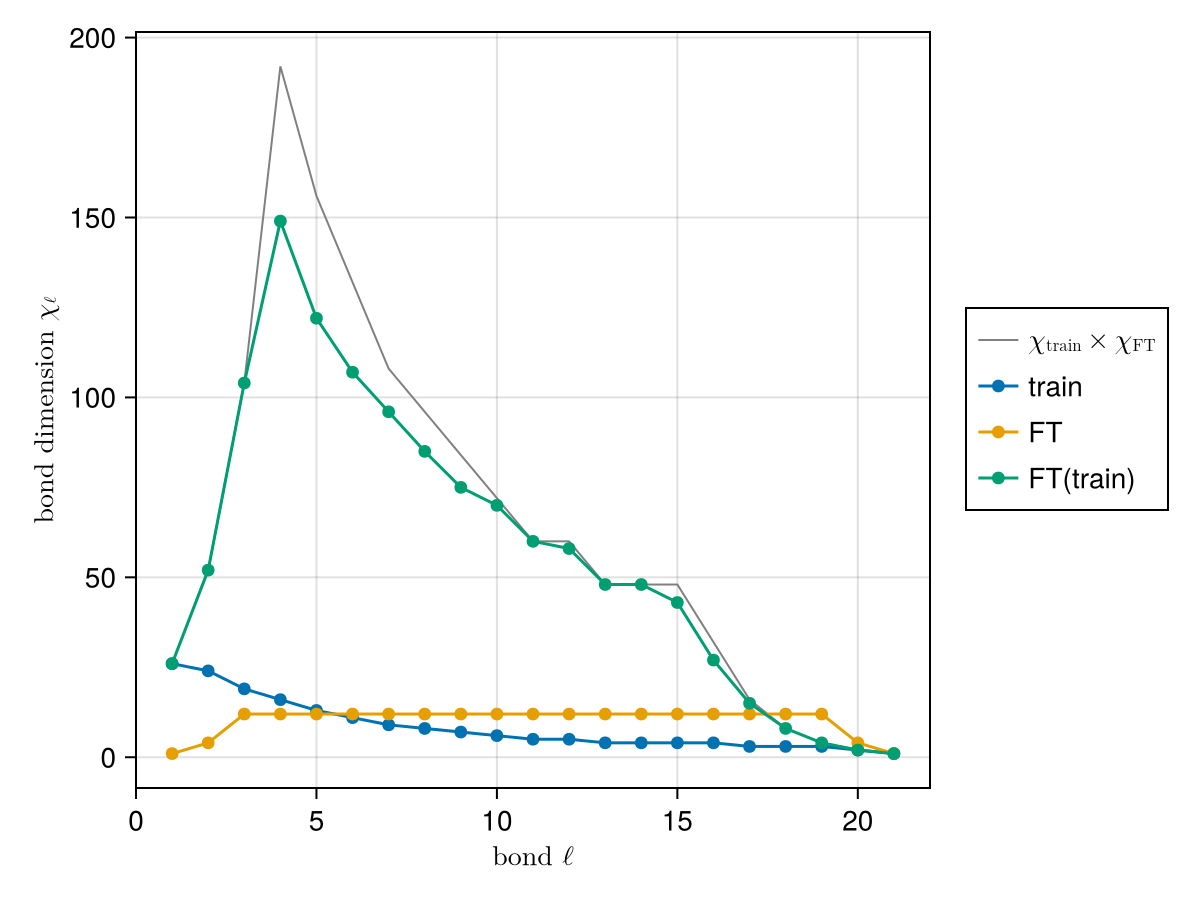

In [155]:
function linkdims(tt::TCI.TensorTrain{V, N}) where {V, N}
    return [
        size(tt[1], 1),
        size.(TCI.sitetensors(tt), ndims.(TCI.sitetensors(tt)))...
    ]
end

maxlinkdims = min.(linkdims(train) .* linkdims(fouriertto), 2 .^ (numbits:-1:0), size(train[1], 1) .* 2 .^ (0:numbits))

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"bond $\ell$", ylabel=L"bond dimension $\chi_\ell$")
lines!(ax, maxlinkdims, color=:gray, linewidth=1, label=L"$\chi_{\mathrm{train}} \times \chi_{\mathrm{FT}}")

scatterlines!(ax, linkdims(train), label="train")
scatterlines!(ax, linkdims(fouriertto), label="FT")
scatterlines!(ax, linkdims(fttrain), label="FT(train)")
Legend(fig[1, 2], ax)
save("precalcfourier.pdf", fig)
fig

In [98]:
linkdims(fouriertto)

11-element Vector{Int64}:
 1
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [99]:
size.(TCI.sitetensors(fouriertto))

10-element Vector{NTuple{4, Int64}}:
 (1, 2, 2, 4)
 (4, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 12)
 (12, 2, 2, 4)
 (4, 2, 2, 1)